In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic lithosphere with different prior for continents and oceans using direct obs"
nb_name = "nb_case_lith_synthetic_direct_obs"

In [2]:
shc_g = 60
shc_grid = 60

lith = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens_alt", sat_height = 350)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)

<IPython.core.display.Javascript object>


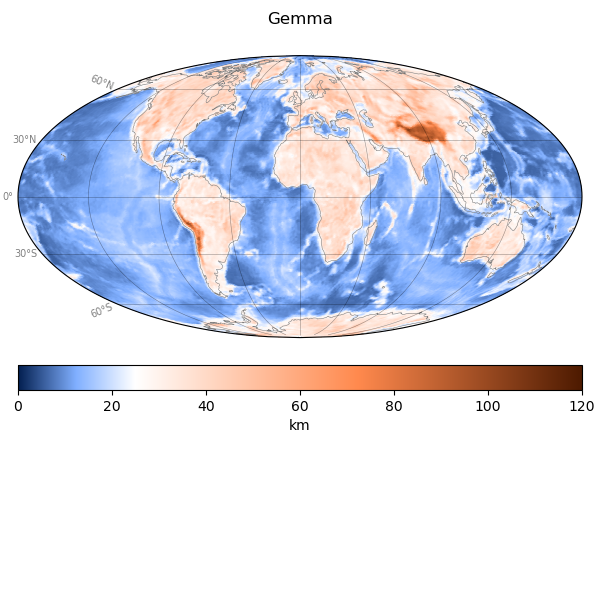

<IPython.core.display.Javascript object>


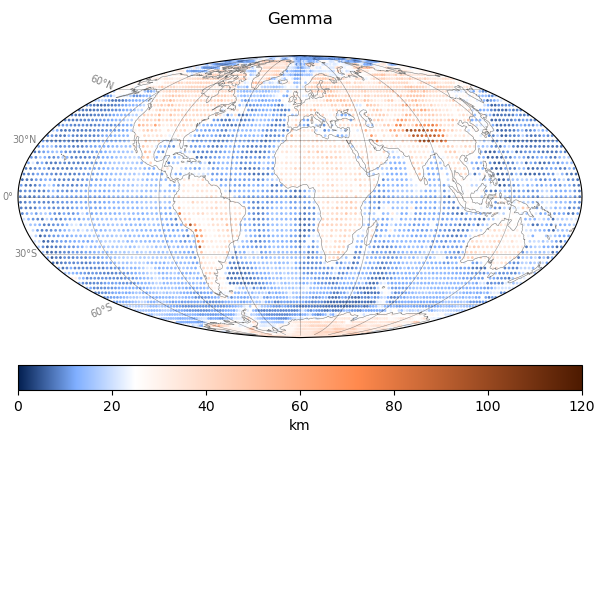

<IPython.core.display.Javascript object>


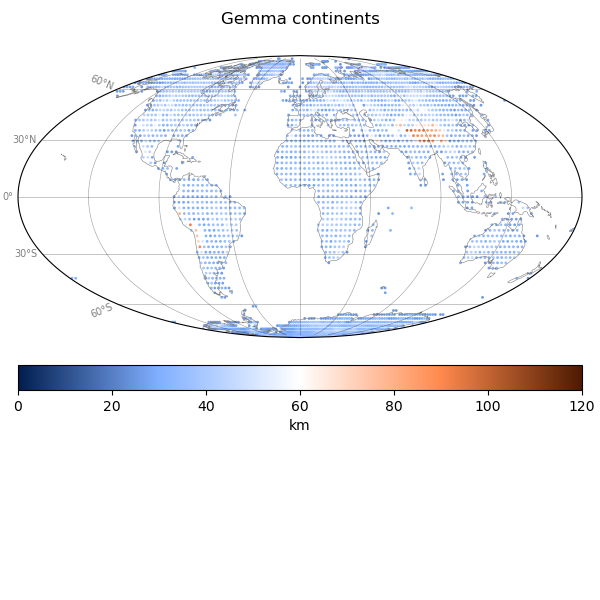

<IPython.core.display.Javascript object>


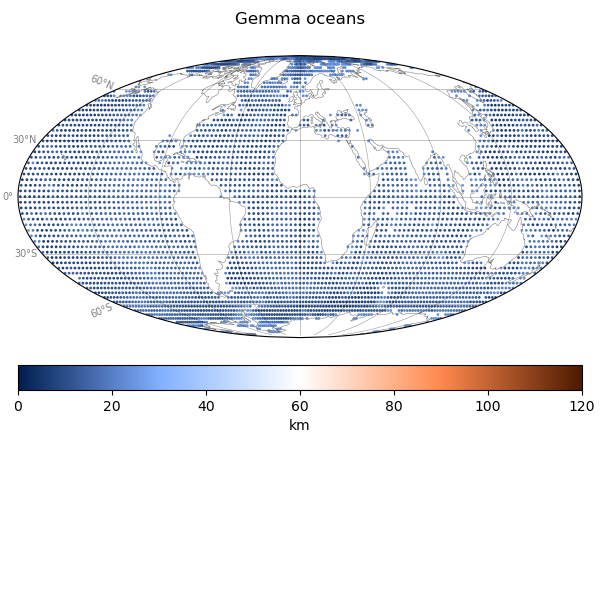

In [3]:
crust_gemma = np.load("mikkel_tools/models_grid/crust_gemma_p05.npy").reshape(360,720)
crust_gemma = np.hstack((crust_gemma[:,360:],crust_gemma[:,:360])).reshape(-1,)
crust_gemma_err = np.load("mikkel_tools/models_grid/crust_gemma_err_p05.npy").reshape(360,720)
crust_gemma_err = np.hstack((crust_gemma_err[:,360:],crust_gemma_err[:,:360])).reshape(-1,)

gemma_phi, gemma_theta = np.meshgrid(np.arange(0,360,0.5), np.arange(0,180,0.5))
gemma_phi = gemma_phi.reshape(-1,)
gemma_theta = gemma_theta.reshape(-1,)

crust_gemma_itp = mt_util.interpolate_grid(gemma_theta, lith.grid_theta, gemma_phi, lith.grid_phi, crust_gemma, 
                                        method_int = "nearest")

mt_util.plot_global(lat = 90-gemma_theta, lon = gemma_phi, data=crust_gemma, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=crust_gemma_itp, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25)

idx_c = crust_gemma_itp>25
idx_o = ~idx_c.copy()

mt_util.plot_global(lat = 90-lith.grid_theta[idx_c], lon = lith.grid_phi[idx_c], data=crust_gemma_itp[idx_c], 
                    limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma continents', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 60)

mt_util.plot_global(lat = 90-lith.grid_theta[idx_o], lon = lith.grid_phi[idx_o], data=crust_gemma_itp[idx_o], 
                    limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma oceans', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 60)

idx_c_cov = idx_c.reshape(-1,1)@idx_c.reshape(1,-1)
idx_o_cov = idx_o.reshape(-1,1)@idx_o.reshape(1,-1)

In [5]:
print(lith)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Synthetic lithosphere with different prior for continents and oceans using direct obs
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             60
N_SH_secondary:   None
sim_type:         lith_ens_alt
grid_zero:        (61,), Max/Min: 1.00 / -1.00
grid_w_shtools:   (61,), Max/Min: 0.05 / 0.00
grid_shape:       (2,), Max/Min: 121.00 / 61.00
grid_w:           (7381,), Max/Min: 0.05 / 0.00
grid_radial:      (7381,), Max/Min: 6371.20 / 6371.20
grid_theta:       (7381,), Max/Min: 177.76 / 2.24
grid_phi:         (7381,), Max/Min: 357.02 / 0.00
grid_N:           7381
grid_nmax:        60



____semi-variogram setup___

Number of data used: 8065584
Max data distance: 19992.516 km
Lag length chosen: 100.0 km
Number of lags: 199
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


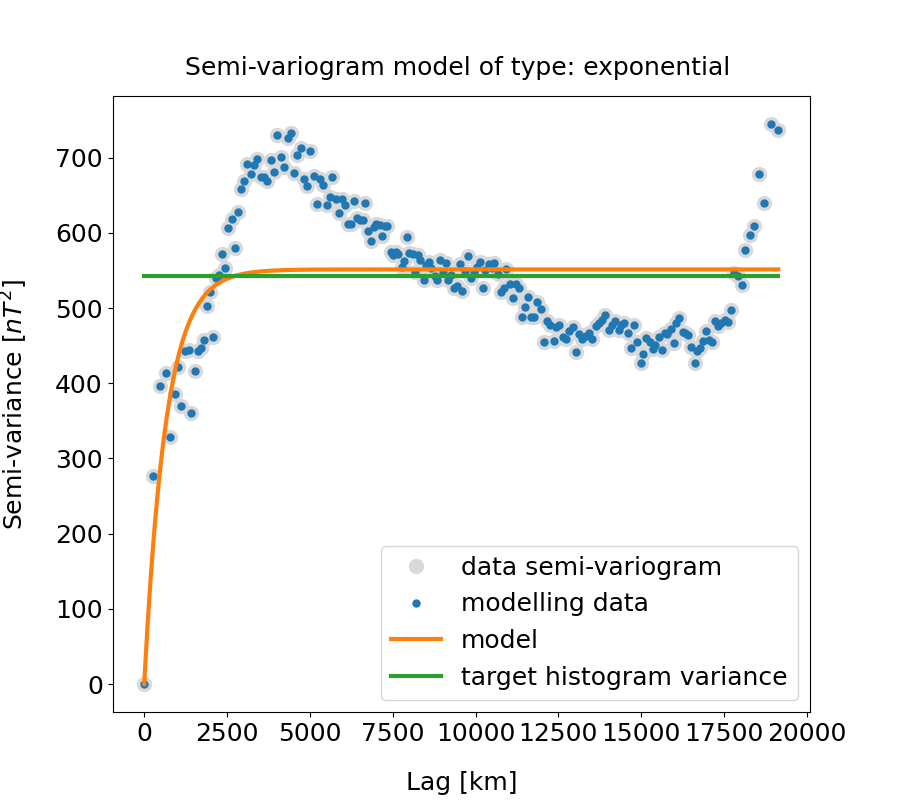

In [6]:
# Continents
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

lith.grid_radial = lith.grid_radial[idx_c]
lith.grid_theta = lith.grid_theta[idx_c]
lith.grid_phi = lith.grid_phi[idx_c]
lith.grid_N = len(lith.grid_phi)
lith.grid_w = lith.grid_w[idx_c]

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 100, zero_nugget = True)

# CONTINENTS
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(9,8)) 
plt.plot(lith.lags,lith.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(lith.lags_model,lith.pics_model,'.',markersize=10,label='modelling data')
plt.plot(lith.lags_sv_curve,lith.sv_curve,color='C1',linewidth = 3,label='model')
plt.plot(lith.lags_sv_curve,np.ones(lith.lags_sv_curve.shape)*lith.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % lith.model_names[lith.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

sv_c = lith.sv_lut.copy()
tv_c = np.max(sv_c)

#lith.condtab(normsize=10000, quantiles = 1000, 
#             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

____semi-variogram setup___

Number of data used: 20620653
Max data distance: 19992.516 km
Lag length chosen: 100.0 km
Number of lags: 199
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


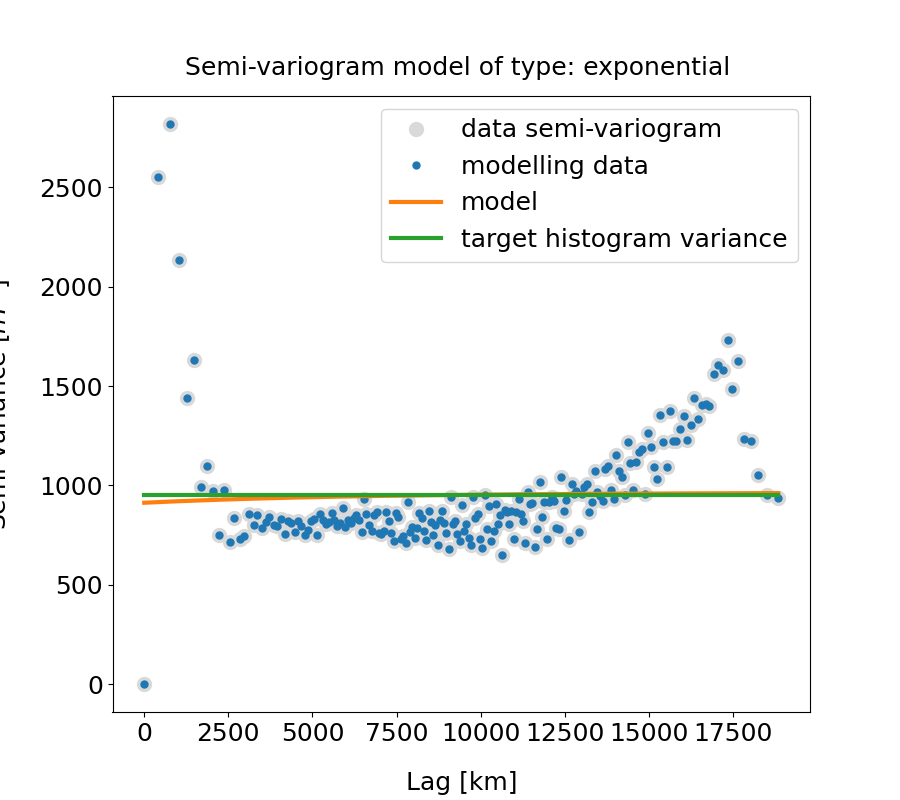

In [7]:
# Oceans
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

lith.grid_radial = lith.grid_radial[idx_o]
lith.grid_theta = lith.grid_theta[idx_o]
lith.grid_phi = lith.grid_phi[idx_o]
lith.grid_N = len(lith.grid_phi)
lith.grid_w = lith.grid_w[idx_o]

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 100, zero_nugget = False)

# OCEANS
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(9,8)) 
plt.plot(lith.lags,lith.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(lith.lags_model,lith.pics_model,'.',markersize=10,label='modelling data')
plt.plot(lith.lags_sv_curve,lith.sv_curve,color='C1',linewidth = 3,label='model')
plt.plot(lith.lags_sv_curve,np.ones(lith.lags_sv_curve.shape)*lith.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % lith.model_names[lith.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

sv_o = lith.sv_lut.copy()
tv_o = np.max(sv_o)

In [8]:
# Combine
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

C_mm_in = np.zeros((lith.grid_N*lith.grid_N,))

C_mm_in[idx_c_cov.reshape(-1,)] = tv_c - sv_c.reshape(-1,)
C_mm_in[idx_o_cov.reshape(-1,)] = tv_o - sv_o.reshape(-1,)

C_mm_in = C_mm_in.reshape(lith.grid_N,lith.grid_N)

#lith.condtab(normsize=10000, quantiles = 1000, 
#             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [9]:
## Regular
#grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
#lith.make_grid(lith.a, grid_in, calc_sph_d = True)
#lith.generate_map()
#
#lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 10, zero_nugget = True)
#
## FULL
##%% PLOT SEMI-VARIOGRAM
#plt.figure(figsize=(9,8)) 
#plt.plot(lith.lags,lith.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
#plt.plot(lith.lags_model,lith.pics_model,'.',markersize=10,label='modelling data')
#plt.plot(lith.lags_sv_curve,lith.sv_curve,color='C1',linewidth = 3,label='model')
#plt.plot(lith.lags_sv_curve,np.ones(lith.lags_sv_curve.shape)*lith.target_var,linewidth = 3, color="C2", label="target histogram variance")
#plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
#plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
#plt.title("Semi-variogram model of type: %s " % lith.model_names[lith.model],fontsize=18,y=1.02)
#plt.legend(loc='best',fontsize=18)
#ax = plt.gca()
#ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
#plt.show()
#
#C_mm_in = lith.target_var-lith.sv_lut

In [10]:
#lith.cov_model_taper(r_at = lith.a, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
#                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
#                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)
#
#lith.cov_model(r_at = lith.a)

#C_mm_in = lith.C_ens_tap

In [11]:
print(lith)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Synthetic lithosphere with different prior for continents and oceans using direct obs
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
N_SH_secondary:        None
sim_type:              lith_ens_alt
grid_zero:             (61,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (61,), Max/Min: 0.05 / 0.00
grid_shape:            (2,), Max/Min: 121.00 / 61.00
grid_w:                (7381,), Max/Min: 0.05 / 0.00
grid_radial:           (7381,), Max/Min: 6371.20 / 6371.20
grid_theta:            (7381,), Max/Min: 177.76 / 2.24
grid_phi:              (7381,), Max/Min: 357.02 / 0.00
grid_N:                7381
grid_nmax:             60
r_grid:                6371.2
grid:                  (7381, 2)
sph_d:            

In [12]:
## Load core object
#file_pickle = open("nb_case_core_synthetic_direct.obj", 'rb')
#core_dobs = pickle.load(file_pickle)
#file_pickle.close()


C_e_const = 0.1
observations_direct_loc = np.random.choice(np.arange(lith.grid_N),size=6500,replace=False)
#observations_direct_loc = core_dobs.observations_direct_loc
observations_direct = lith.data[observations_direct_loc] + np.random.normal(loc=0.0,scale=C_e_const,size=observations_direct_loc.shape)

#core_dobs = None

lith.observations_direct_loc = observations_direct_loc

In [13]:
#print(observations_direct_loc)

In [8]:
#C_e_const = 2.0
#
#s_sat = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)
#
#s_sat.load_swarm("A")
#
#grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
#s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)
#
#s_sat.generate_map(grid_type = "swarm")
#
#s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [14]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens_alt", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = s_source.a)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.a, grid_in, calc_sph_d = False)

s_source.generate_map()

In [56]:
#s_source.ensemble_B(s_source.g_prior, nmax = shc_g, r_at = s_source.a, grid_type = "glq")
#m_lith_truth = s_source.B_ensemble[:,0].copy()
#
#idx_lowpass = np.abs(m_lith_truth)<3
#
#print(m_lith_truth[idx_lowpass].shape)

(2395,)


# SDSSIM

In [13]:
C_mm_in[observations_direct_loc,observations_direct_loc] += C_e_const

In [14]:
lith.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [18]:
N_sim = 10
#lith.target_var = np.max(lith.C_mm_all)

#lith.run_sim(N_sim, lith.grid_N, lith.C_mm_all, lith.C_dd, lith.C_dm_all, lith.G,
#        s_sat.data, lith.data, scale_m_i = True, unit_d = False, collect_all = True,
#        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

lith.run_sim(N_sim, lith.grid_N, C_mm_in, None, None, None,
        None, lith.data, 
        observations_direct = observations_direct, observations_direct_loc = observations_direct_loc, 
        observations_direct_e = C_e_const, use_sgs = False,
        scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 7381/7381, Running error magnitude: 0.1
Run time: 18.388 minutes 
Total elapsed time: 18.388 minutes 
Variance: 2074.744
Mean: -1.448
Max: 267.284
Min: -528.727
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 7381/7381, Running error magnitude: 0.1
Run time: 18.506 minutes 
Total elapsed time: 36.894 minutes 
Variance: 2075.983
Mean: -1.437
Max: 267.284
Min: -528.727
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 7381/7381, Running error magnitude: 0.1
Run time: 18.469 minutes 
Total elapsed time: 55.363 minutes 
Variance: 2079.706
Mean: -1.359
Max: 267.284
Min: -528.727
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 7381/7381, Running error magnitude: 0.1
Run time: 18.481 minutes 
Total elapsed time: 1.231 hours 
Variance: 2073.780
Mean: -1.443
Max: 267.284
Min: -528.727
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 7381/7381, Running error magnitude: 0.1
Run time: 18.462

In [19]:
lith.realization_to_sh_coeff(lith.a, set_nmax = shc_grid)

<IPython.core.display.Javascript object>


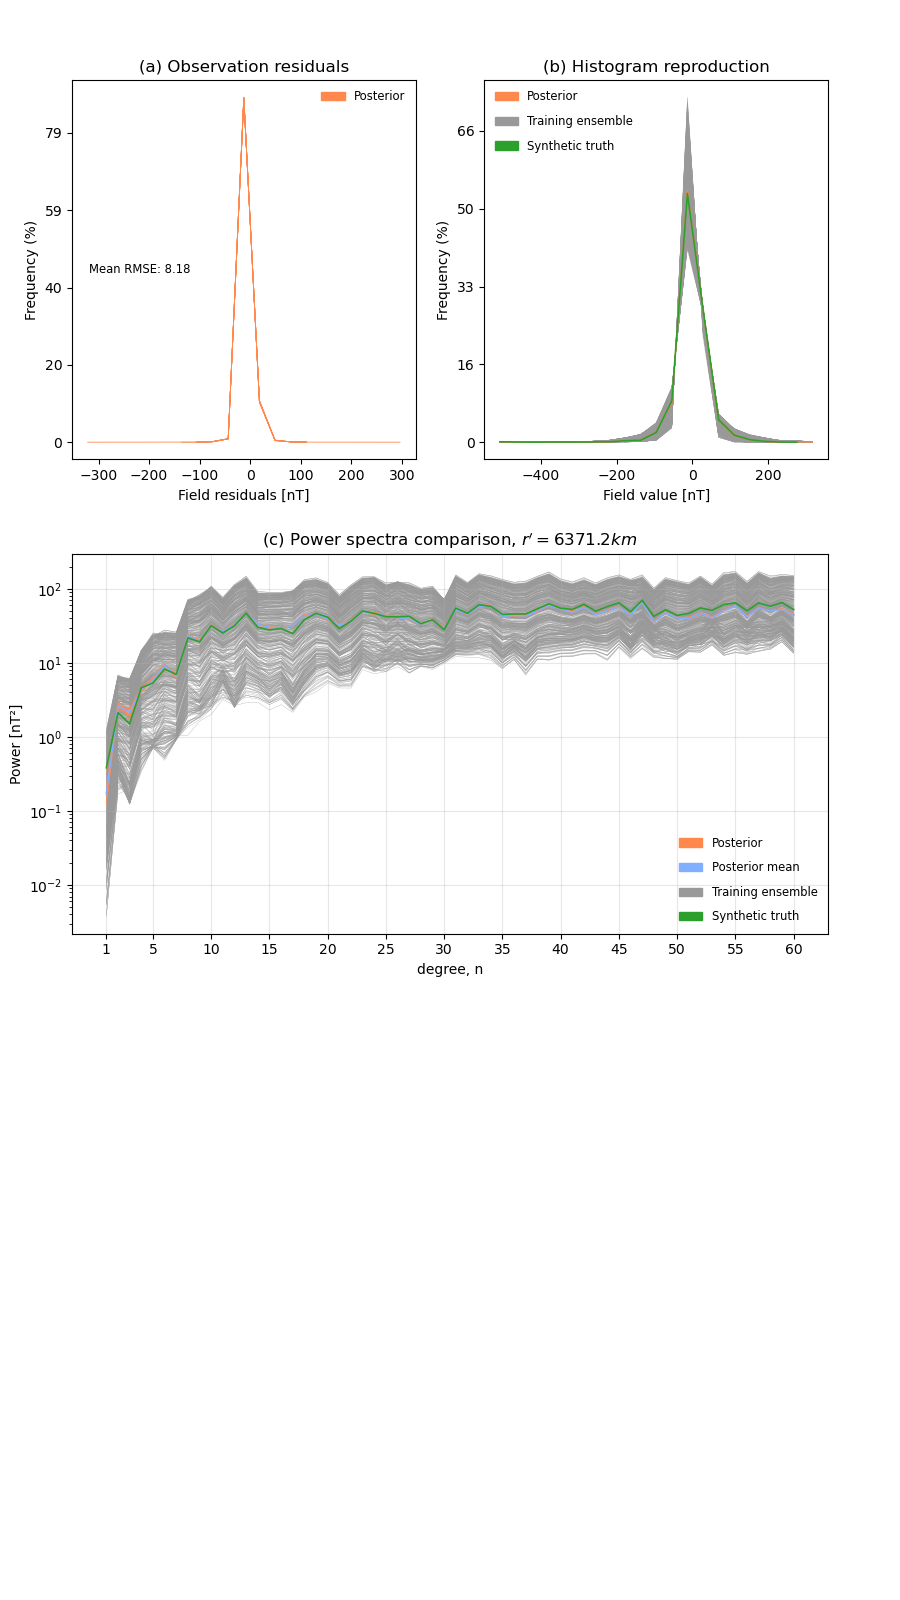

In [22]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.m_DSS_res = lith.m_DSS - s_source.data.reshape(-1,1)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.a, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 0.6, lwidth_div = 3, lwidth_mult = 2,
                              label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[nT]",
                              unit_transform_n_to_m = False, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 21, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic_direct_obs", 
                              save_dpi = 100, save_path = "images/")

In [23]:
#lith.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [25]:
lith.grid_glq(nmax = 256, r_at = lith.a)

set_nmax = shc_grid

lith.ensemble_B(lith.g_spec, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_eqa = lith.B_ensemble[:,0,:].copy()

lith.ensemble_B(lith.g_spec_mean, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_mean_eqa = lith.B_ensemble[:,0].copy()

lith.ensemble_B(s_source.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = lith.a, grid_type = "glq")
prior_eqa = lith.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


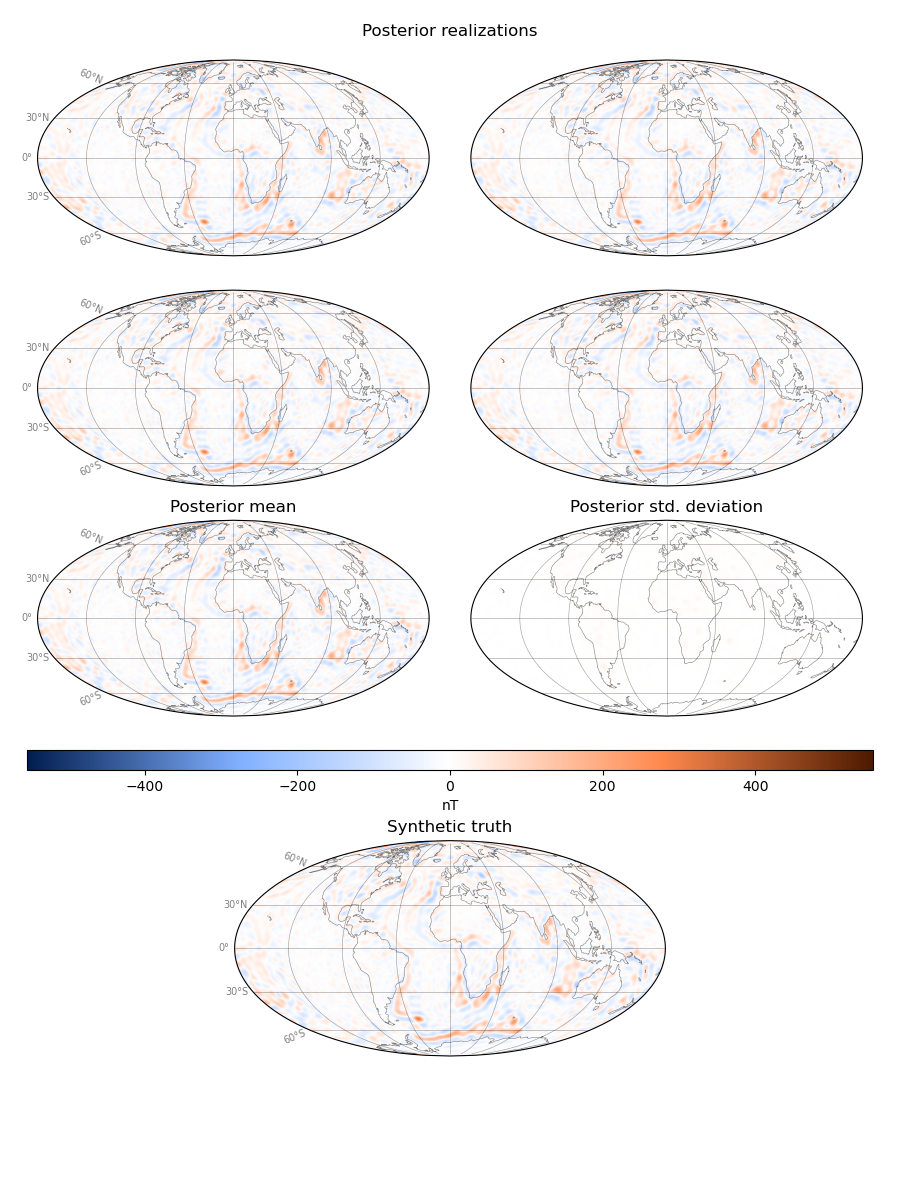

In [26]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(lith.grid_phi, 90-lith.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_lith_synthetic_direct_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100, save_path = "images/")
